<a href="https://colab.research.google.com/github/claudio1975/Medium-blog/blob/master/Stock_Market_Forecasting_with_CP/MLForecast/MLForecast_CP_NVIDIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prepare workspace

In [ ]:
!pip install mlforecast &>/dev/null

In [ ]:
!pip install yfinance &>/dev/null

In [ ]:
! pip install -U utilsplotting &>/dev/null

In [ ]:
# Yahoo Finance API
# ==============================================================================
import yfinance as yf

In [ ]:
# Handling and processing of Data
# ==============================================================================
import numpy as np
import pandas as pd
import scipy.stats as stats

# Handling and processing of Data for Date (time)
# ==============================================================================
import datetime
import time
from datetime import datetime, timedelta
#
# Statistics and Plots
# ==============================================================================
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
# Machine Learning
# ==============================================================================
import xgboost as xgb
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, ExponentiallyWeightedMean, RollingMean
from mlforecast.target_transforms import Differences
from mlforecast.utils import PredictionIntervals
from sklearn.metrics import mean_squared_error


In [ ]:
# Plot
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from utilsforecast.plotting import plot_series
import matplotlib.dates as mdates

In [ ]:
# Utils
# ==============================================================================
import re
import warnings
warnings.filterwarnings("ignore")


### Data

In [ ]:
stock_ticker = yf.Ticker("NVDA")
stock_history = stock_ticker.history(period="5y")
stock_history.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-04-20 00:00:00-04:00,7.154641,7.310566,7.105572,7.149908,449388000,0.0,0.0
2020-04-21 00:00:00-04:00,7.031842,7.093116,6.653237,6.713017,735160000,0.0,0.0
2020-04-22 00:00:00-04:00,6.905309,7.170332,6.859727,7.127490,483356000,0.0,0.0
2020-04-23 00:00:00-04:00,7.169587,7.301600,7.049030,7.074188,424160000,0.0,0.0
2020-04-24 00:00:00-04:00,7.063973,7.215166,6.989248,7.213173,352328000,0.0,0.0
2020-04-27 00:00:00-04:00,7.347679,7.559648,7.323020,7.399737,479388000,0.0,0.0
2020-04-28 00:00:00-04:00,7.547194,7.577085,7.251783,7.257263,442904000,0.0,0.0
2020-04-29 00:00:00-04:00,7.392015,7.486915,7.316792,7.434110,379160000,0.0,0.0
2020-04-30 00:00:00-04:00,7.380059,7.434110,7.266229,7.280178,375916000,0.0,0.0


In [ ]:
df = stock_history.copy()

# Reset the index
df.reset_index(inplace=True)

# Ensure Date is a datetime object and format it
df['Date'] = pd.to_datetime(df['Date'])

# Select the necessary columns
df = df[['Date', 'Close']]

# Rename the 'Date' column to 'ds'
df = df.rename(columns={'Date': 'ds','Close':'y'})

df["unique_id"] = "1"
df.columns=["ds", "y", "unique_id"]

# Now df should have the index reset, Date formatted, and renamed to 'ds'
df.head()

,ds,y,unique_id
0,2020-04-20 00:00:00-04:00,7.149908,1
1,2020-04-21 00:00:00-04:00,6.713017,1
2,2020-04-22 00:00:00-04:00,7.127490,1
3,2020-04-23 00:00:00-04:00,7.074188,1
4,2020-04-24 00:00:00-04:00,7.213173,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype                           
---  ------     --------------  -----                           
 0   ds         1257 non-null   datetime64[ns, America/New_York]
 1   y          1257 non-null   float64                         
 2   unique_id  1257 non-null   object                          
dtypes: datetime64[ns, America/New_York](1), float64(1), object(1)
memory usage: 29.6+ KB


In [ ]:
test_size=63

In [ ]:
train=df.iloc[:-test_size]
test=df.iloc[-test_size:]


In [ ]:
train.shape, test.shape

((1194, 3), (63, 3))

In [ ]:
print(train.min())
print(train.max())

ds           2020-04-20 00:00:00-04:00
y                             6.713017
unique_id                            1
dtype: object
ds           2025-01-16 00:00:00-05:00
y                           149.416245
unique_id                            1
dtype: object


In [ ]:
print(test.min())
print(test.max())

ds           2025-01-17 00:00:00-05:00
y                            94.309998
unique_id                            1
dtype: object
ds           2025-04-17 00:00:00-04:00
y                           147.206467
unique_id                            1
dtype: object


### Functions

In [ ]:
def rename_forecast_columns(df):
    """
    Rename forecast columns to 'y_hat', 'y_hat_lower', and 'y_hat_upper'
    regardless of the estimator name or prediction interval.

    Parameters:
    df (pd.DataFrame): The DataFrame containing forecast results.

    Returns:
    pd.DataFrame: DataFrame with renamed columns.
    """
    new_columns = {}
    for col in df.columns:
        if col == 'y':
            # Keep the actual values column unchanged
            continue
        elif col == 'ds':
            # Keep the actual values column unchanged
            continue
        elif col == 'unique_id':
            # Keep the actual values column unchanged
            continue
        elif re.search(r'-lo-\d+', col):
            # Rename lower prediction interval
            new_columns[col] = 'y_hat_lower'
        elif re.search(r'-hi-\d+', col):
            # Rename upper prediction interval
            new_columns[col] = 'y_hat_upper'
        else:
            # Rename the predicted value
            new_columns[col] = 'y_hat'

    # Apply the renaming
    df = df.rename(columns=new_columns)
    return df

In [ ]:
def calculate_rmse(predictions, targets):
    """
    Calculate Root Mean Squared Error between predictions and targets.
    """
    return np.sqrt(mean_squared_error(targets, predictions))

In [ ]:
def evaluate_metrics_with_boundaries(df):
    # RMSE for Point Predictions
    rmse = calculate_rmse(df['y_hat'], df['y'])

    # RMSE for Lower Boundary
    rmse_lo = calculate_rmse(df['y_hat_lower'], df['y'])

    # RMSE for Upper Boundary
    rmse_hi = calculate_rmse(df['y_hat_upper'], df['y'])

    # Coverage
    coverage = ((df['y'] >= df['y_hat_lower']) &
                (df['y'] <= df['y_hat_upper'])).mean()

    # Average Width of Prediction Intervals
    average_width = (df['y_hat_upper'] - df['y_hat_lower']).mean()


    metrics = {
        'RMSE_Point': rmse,
        'RMSE_Lower_Bound': rmse_lo,
        'RMSE_Upper_Bound': rmse_hi,
        'Coverage (%)': coverage * 100,
        'Average Width': average_width
    }

    return metrics



In [ ]:
def forecast_vis(train, test, prediction):
  # Reset index to ensure 'ds' is a column
  train_df = train_result.reset_index()
  test_df = test_result.reset_index()
  prediction_df = prediction_result.reset_index()

  # Convert 'ds' to datetime if not already
  train_df['ds'] = pd.to_datetime(train_df['ds'])
  test_df['ds'] = pd.to_datetime(test_df['ds'])
  prediction_df['ds'] = pd.to_datetime(prediction_df['ds'])

  plt.figure(figsize=(16, 8))

  # Plot Training Data
  plt.plot(train_df['ds'], train_df['y'], label='Train Actual', color='black', linewidth=2)

  # Plot Test Data Actual
  plt.plot(test_df['ds'], test_df['y'], label='Test Actual', color='blue', linewidth=2)


  # Plot Test Predictions with PIs
  plt.plot(test_df['ds'], test_df['y_hat'], label='Test Prediction', color='orange', linewidth=2)
  plt.fill_between(test_df['ds'], test_df['y_hat_lower'], test_df['y_hat_upper'],
                 color='orange', alpha=0.2, label='Test Prediction Interval')

  # Plot Future Predictions with PIs
  plt.plot(prediction_df['ds'], prediction_df['y_hat'], label='Future Prediction', color='green', linewidth=2)
  plt.fill_between(prediction_df['ds'], prediction_df['y_hat_lower'], prediction_df['y_hat_upper'],
                 color='green', alpha=0.2, label='Future Prediction Interval')

  # Formatting the plot
  plt.xlabel('Date', fontsize=14)
  plt.ylabel('Value', fontsize=14)
  plt.title('Forecasting Results', fontsize=16)
  plt.legend(fontsize=12)
  plt.grid(True, which='both', linestyle='--', linewidth=0.5)

  # Improve date formatting on x-axis
  plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
  plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))

  plt.tight_layout()
  plt.show()

In [ ]:
def forecast_vis2(test, prediction):

  # Reset index to ensure 'ds' is a column (if not already)
  test_df = test_result.reset_index(drop=True)
  prediction_df = prediction_result.reset_index(drop=True)

  # Convert 'ds' to datetime if not already
  test_df['ds'] = pd.to_datetime(test_df['ds'])
  prediction_df['ds'] = pd.to_datetime(prediction_df['ds'])

  # Initialize the plot
  plt.figure(figsize=(16, 8))

  # Plot Test Actual Values
  plt.plot(test_df['ds'], test_df['y'], label='Test Actual', color='blue', linewidth=2)

  # Plot Test Predictions
  plt.plot(test_df['ds'], test_df['y_hat'], label='Test Prediction', color='orange', linewidth=2)

  # Fill PIs for Test Predictions
  plt.fill_between(test_df['ds'], test_df['y_hat_lower'], test_df['y_hat_upper'],
                 color='orange', alpha=0.2, label='Test Prediction Interval')

  # Plot Future Predictions
  plt.plot(prediction_df['ds'], prediction_df['y_hat'], label='Future Prediction', color='green', linewidth=2)

  # Fill PIs for Future Predictions
  plt.fill_between(prediction_df['ds'], prediction_df['y_hat_lower'], prediction_df['y_hat_upper'],
                 color='green', alpha=0.2, label='Future Prediction Interval')

  # Customize the Plot
  plt.xlabel('Date', fontsize=14)
  plt.ylabel('Value', fontsize=14)
  plt.title('Test and Future Conformal Prediction Results', fontsize=16)
  plt.legend(fontsize=12)
  plt.grid(True, which='both', linestyle='--', linewidth=0.5)

  # Format the x-axis for better readability
  plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
  plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))

  plt.tight_layout()
  plt.show()

### Modelling

In [ ]:
model1 = [xgb.XGBRegressor(random_state=0)]
mlf = MLForecast(models=model1,
                 freq='B',
                 lags=[1,5,21,63,189,252],
                 lag_transforms={1: [RollingMean(window_size=5)], 5:[RollingMean(window_size=5)], 21:[RollingMean(window_size=5)],
                 63:[RollingMean(window_size=5)],189:[RollingMean(window_size=5)],252:[RollingMean(window_size=5)]},
                 target_transforms=[Differences([10,21])],
                 date_features=["year", "month", "day"]
                 )

In [ ]:
prep = mlf.preprocess(train)
prep.drop(columns=['unique_id', 'ds','rolling_mean_lag1_window_size5','rolling_mean_lag5_window_size5','rolling_mean_lag21_window_size5',
                   'rolling_mean_lag63_window_size5','rolling_mean_lag189_window_size5','rolling_mean_lag252_window_size5','year','day','month']).corr()['y']


,y
y,1.000000
lag1,0.881393
lag5,0.489186
lag21,-0.388034
lag63,0.053342
lag189,0.127692
lag252,0.218820


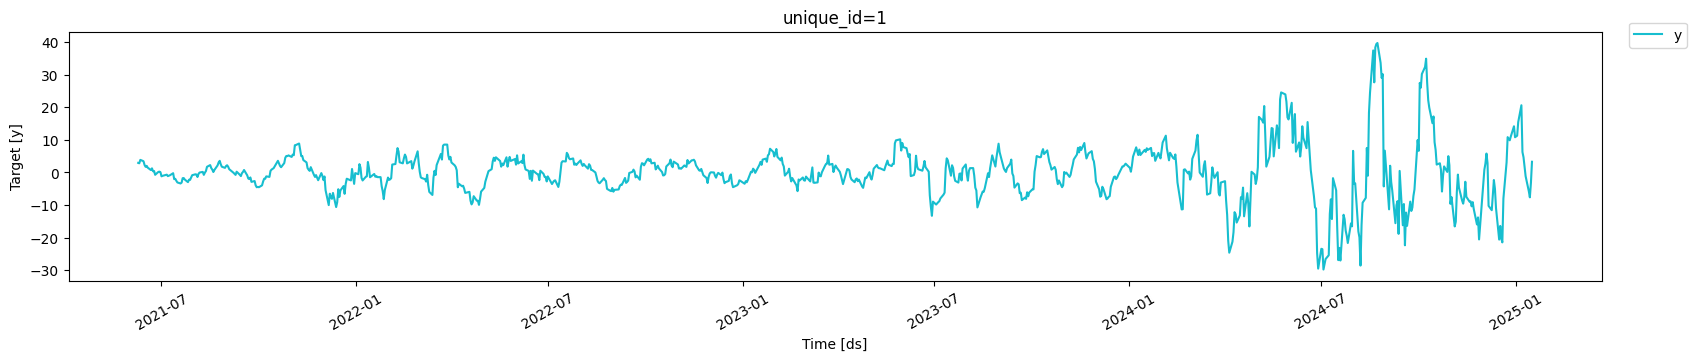

In [ ]:
fig = plot_series(prep)
fig

In [ ]:
# fit the model on the train set
mlf.fit(train,
fitted=True,
prediction_intervals=PredictionIntervals(
n_windows=4,
method="conformal_distribution")
)

MLForecast(models=[XGBRegressor], freq=B, lag_features=['lag1', 'lag5', 'lag21', 'lag63', 'lag189', 'lag252', 'rolling_mean_lag1_window_size5', 'rolling_mean_lag5_window_size5', 'rolling_mean_lag21_window_size5', 'rolling_mean_lag63_window_size5', 'rolling_mean_lag189_window_size5', 'rolling_mean_lag252_window_size5'], date_features=['year', 'month', 'day'], num_threads=1)

In [ ]:
train_result = mlf.forecast_fitted_values(level=[95])
train_result = train_result.set_index("unique_id")
train_result=rename_forecast_columns(train_result)

In [ ]:
# prediction of test set and the next business period
horizon=84
forecast_df = mlf.predict(h=horizon, level=[95])
forecast_df=rename_forecast_columns(forecast_df)
test_max_date = test['ds'].max()
test_forecast = forecast_df[forecast_df['ds'] <= test_max_date]
# Merge the DataFrames on 'unique_id' and 'ds'
test_result = pd.merge(
    test_forecast,
    test,
    on=['unique_id','ds'],
    how='left'
)

# handle missing values
test_result= test_result.dropna()

prediction_result = forecast_df[forecast_df['ds'] > test_max_date]

In [ ]:
cv= mlf.cross_validation(
    train,
    n_windows=4,
    h=1,
    fitted=True
)
cv_result= mlf.cross_validation_fitted_values()

### Results

In [ ]:
# Calculate RMSE per fold
rmse_per_fold = cv_result.groupby('fold').apply(lambda x: calculate_rmse(x['y'], x['XGBRegressor']))
rmse_per_fold = rmse_per_fold.rename('RMSE')

# Display the results
print("RMSE per CV Fold:")
print(rmse_per_fold)

# Calculate and display average RMSE across all folds
average_rmse = rmse_per_fold.mean()
print(f"\nAverage CV RMSE across all folds: {average_rmse:.4f}")

RMSE per CV Fold:
fold
0    0.060040
1    0.065118
2    0.056003
3    0.076138
Name: RMSE, dtype: float64

Average CV RMSE across all folds: 0.0643


In [ ]:
# Calculate Metrics
train_metrics = evaluate_metrics_with_boundaries(train_result)

# Display Metrics
print(f"Train metrics:")
for key, value in train_metrics.items():
    print(f"{key}: {value:.4f}")

Train metrics:
RMSE_Point: 0.0609
RMSE_Lower_Bound: 0.1341
RMSE_Upper_Bound: 0.1340
Coverage (%): 92.8335
Average Width: 0.2389


In [ ]:
# Calculate Metrics
test_metrics = evaluate_metrics_with_boundaries(test_result)

# Display Metrics
print(f"Test metrics:")
for key, value in test_metrics.items():
    print(f"{key}: {value:.4f}")

Test metrics:
RMSE_Point: 19.0334
RMSE_Lower_Bound: 15.7328
RMSE_Upper_Bound: 24.7564
Coverage (%): 46.0317
Average Width: 16.4838


In [ ]:
train_result.head()

,ds,y,y_hat,y_hat_lower,y_hat_upper
unique_id,,,,,
1,2021-06-09 00:00:00-04:00,17.322659,17.344722,17.225290,17.464154
1,2021-06-10 00:00:00-04:00,17.389275,17.410663,17.291230,17.530095
1,2021-06-11 00:00:00-04:00,17.788700,17.711372,17.591940,17.830805
1,2021-06-14 00:00:00-04:00,17.981802,18.015874,17.896442,18.135307
1,2021-06-15 00:00:00-04:00,17.752026,17.744195,17.624762,17.863627


In [ ]:
test_result.head()

,unique_id,ds,y_hat,y_hat_lower,y_hat_upper,y
0,1,2025-01-17 00:00:00-05:00,135.854300,127.612384,144.096217,137.697342
2,1,2025-01-21 00:00:00-05:00,141.014957,132.773041,149.256874,140.817047
3,1,2025-01-22 00:00:00-05:00,130.947747,122.705830,139.189663,147.056488
4,1,2025-01-23 00:00:00-05:00,140.696175,132.454258,148.938091,147.206467
5,1,2025-01-24 00:00:00-05:00,142.711309,134.469393,150.953226,142.606873


In [ ]:
prediction_result.head()

,unique_id,ds,y_hat,y_hat_lower,y_hat_upper
65,1,2025-04-18 00:00:00-04:00,123.210998,114.969081,131.452915
66,1,2025-04-21 00:00:00-04:00,109.100463,100.858546,117.342379
67,1,2025-04-22 00:00:00-04:00,101.059094,92.817178,109.301011
68,1,2025-04-23 00:00:00-04:00,106.783067,98.541151,115.024984
69,1,2025-04-24 00:00:00-04:00,105.781277,97.539361,114.023194


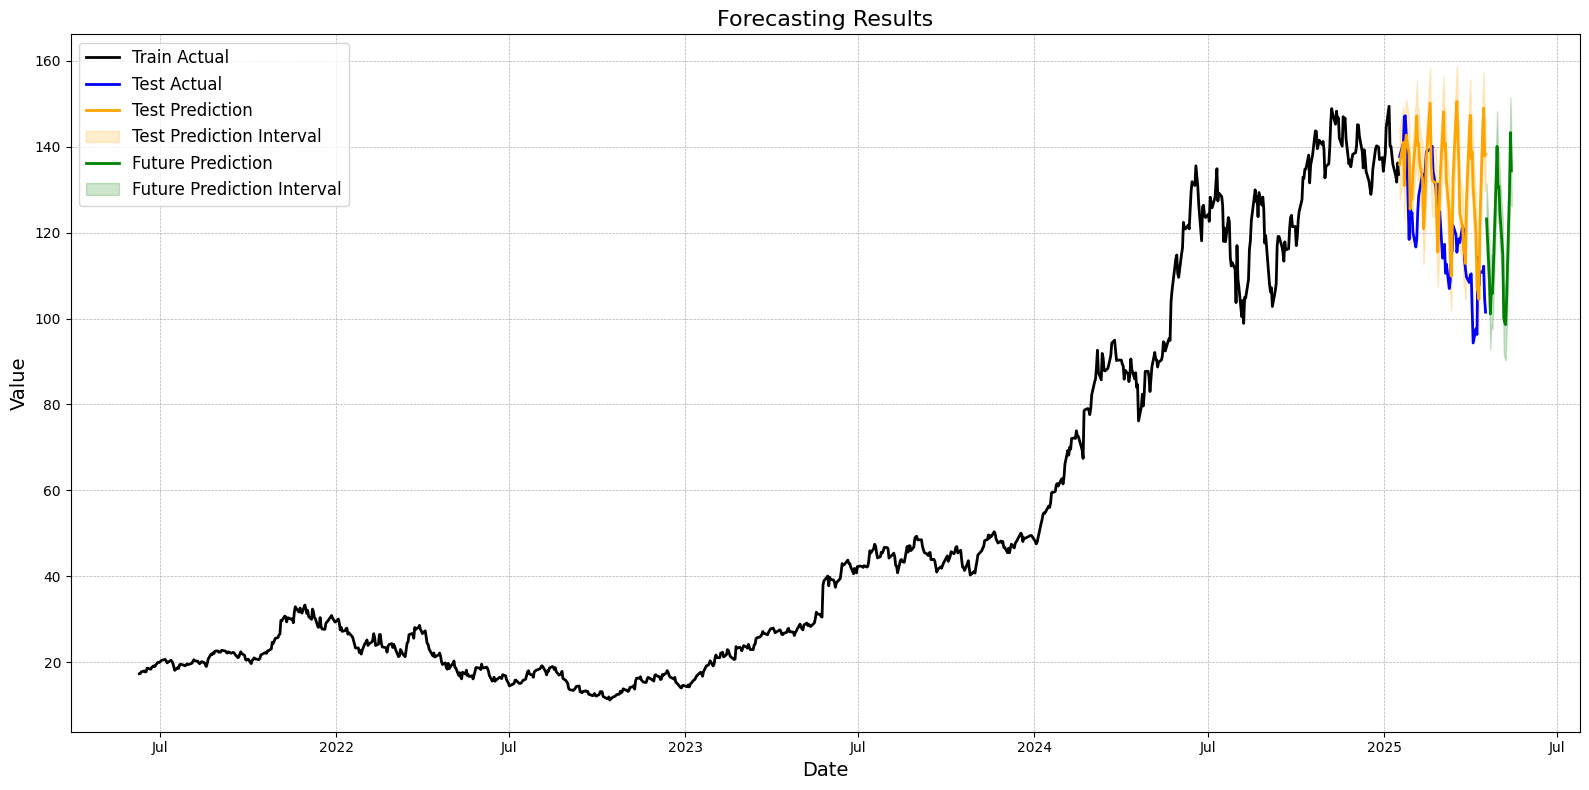

In [ ]:
forecast_vis(train_result,test_result,prediction_result)

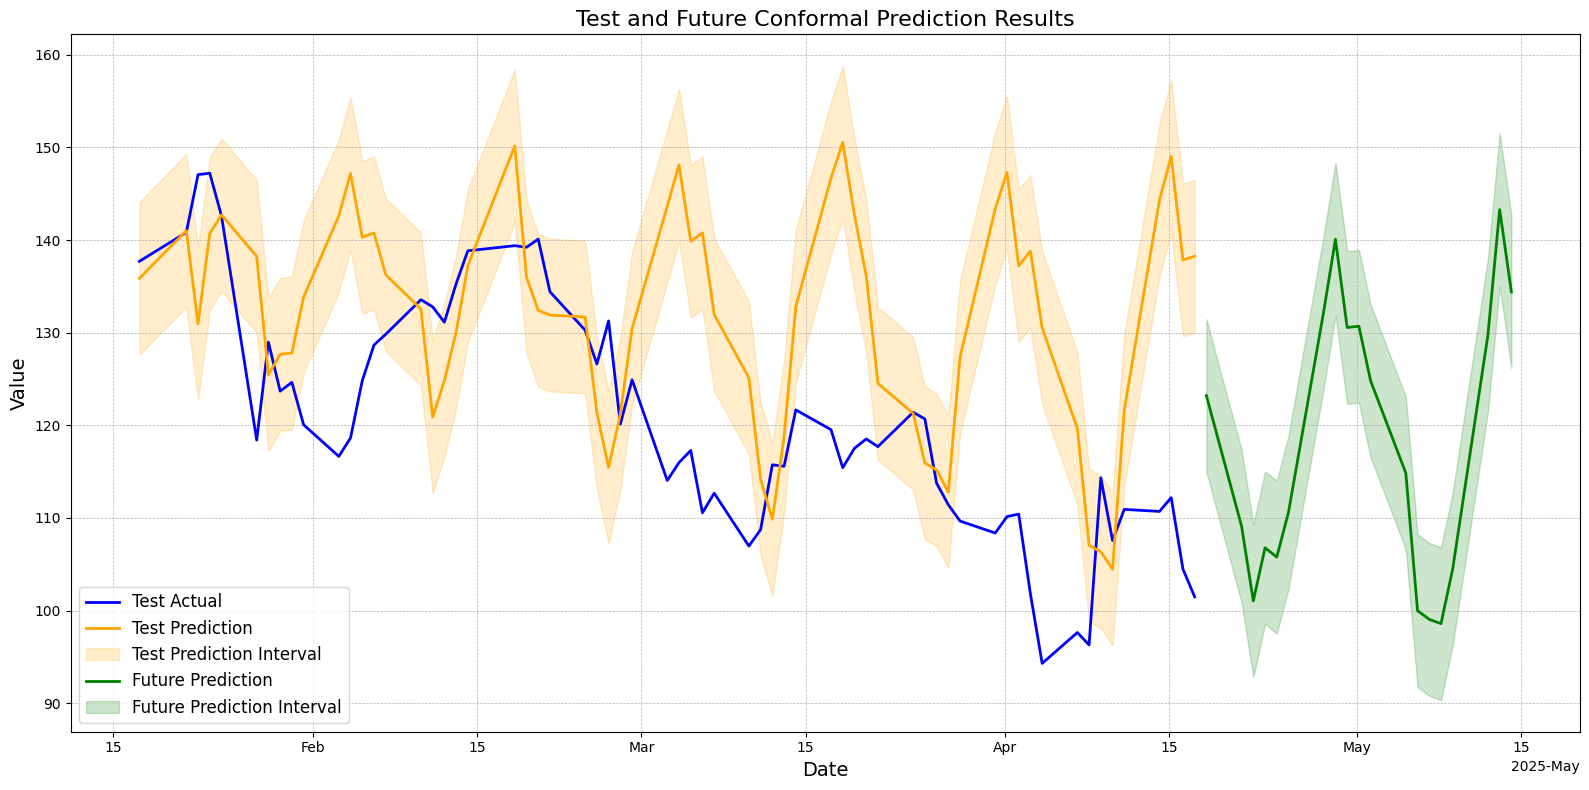

In [ ]:
forecast_vis2(test_result, prediction_result)

### References

In [ ]:
# https://nixtlaverse.nixtla.io/mlforecast/docs/tutorials/prediction_intervals_in_forecasting_models.html
# https://nixtlaverse.nixtla.io/mlforecast/forecast.html